In [45]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# --- Trick to make the notebook recognize the parent directory ---
# --- for importing the custom modules (like db_connector) ---
# It adds the project's root directory to Python's path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# --------------------------------------------------------------------------

# Import the custom connector
from utils.db_connector import get_db_connection

# Get the database connection
conn = get_db_connection()

Database connection successful.


In [46]:
# Check if the connection is successful before proceeding
if conn:
    # --- The main SQL Query ---
    # We join the three tables to get a comprehensive view of the data.
    # - sales JOIN customers on customer_id
    # - the result JOIN products on product_id
    sql_query = """
    SELECT
        s.sale_id,
        s.sale_date,
        s.quantity,
        c.customer_id,
        c.first_name,
        c.last_name,
        c.email,
        p.product_id,
        p.product_name,
        p.price,
        -- Calculate the total revenue for each sale
        (s.quantity * p.price) AS total_revenue
    FROM
        sales AS s
    JOIN
        customers AS c ON s.customer_id = c.customer_id
    JOIN
        products AS p ON s.product_id = p.product_id
    ORDER BY
        s.sale_date DESC;
    """

    # Use pandas to execute the query and load the result into a DataFrame
    df = pd.read_sql_query(sql_query, conn)

    # --- IMPORTANT: Close the connection when it's done ---
    conn.close()
    print("Database connection closed.")
    
    # Display the first few rows of the resulting DataFrame to verify
    print(df.head())
else:
    print("Connection to the database failed. Cannot perform analysis.")

Database connection closed.
   sale_id                        sale_date  quantity  customer_id first_name  \
0       69 2025-10-07 12:08:31.135374+00:00         4           35    Timothy   
1       36 2025-10-05 09:41:08.142684+00:00         4           30     Karina   
2       80 2025-10-03 00:08:13.580591+00:00         3            2      Brian   
3       17 2025-09-30 12:24:18.620547+00:00         3           29   Jonathan   
4       34 2025-09-30 09:38:18.245175+00:00         1            9    Rebecca   

  last_name                       email  product_id            product_name  \
0      Tran       stephen18@example.org           4       Gaming Desk Chair   
1     Moody  sandersallison@example.com           8         Wireless Webcam   
2  Mcdonald      onicholson@example.net          12  Bluetooth Laptop Stand   
3       Fox      qfernandez@example.org           7      Waterproof Speaker   
4   Pittman         danny41@example.com           2          Wireless Mouse   

    price 

/tmp/ipykernel_116208/19290941.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


# 1. Key Performance Indicators (KPIs)

These are the high-level metrics that give us a quick overview of the business's health.

In [47]:
# KPI 1: Total Revenue
# This is the most fundamental measure of a business's performance.
total_revenue = df['total_revenue'].sum()

print(f"Total Revenue: ${total_revenue:,.2f}")

Total Revenue: $109,160.73


In [48]:
# KPI 2: Average Order Value (AOV)
# This tells us, on average, how much a customer spends in a single transaction.
average_order_value = df['total_revenue'].mean()

print(f"Average Order Value (AOV): ${average_order_value:,.2f}")

Average Order Value (AOV): $545.80


--- Top 5 Products by Revenue ---


product_name
Portable Laptop Stand     14693.28
Portable Headphones        9693.54
Bluetooth Laptop Stand     9079.80
Compact Monitor            9076.48
Gaming Monitor             7817.28
Name: total_revenue, dtype: float64

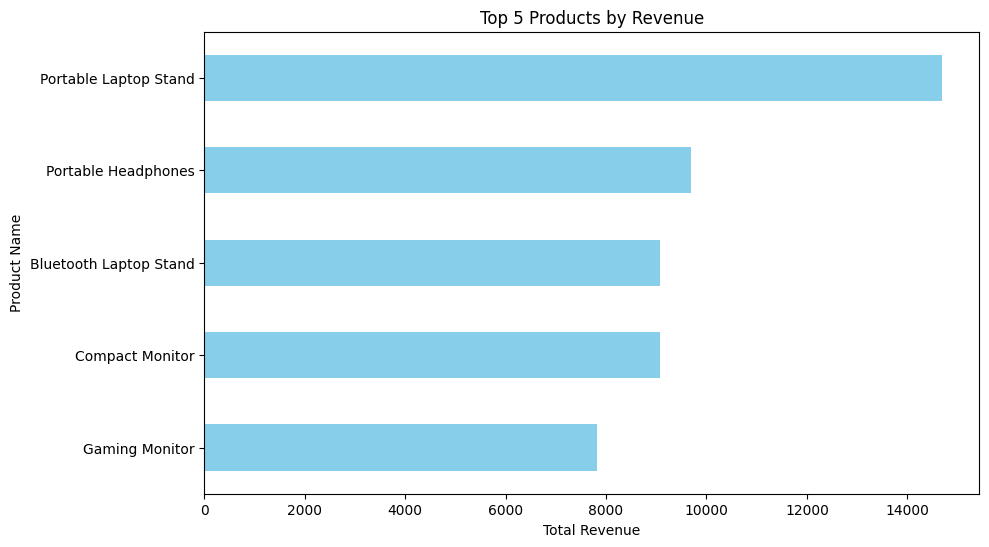

In [49]:
# KPI 3: Top 5 Products by Revenue
# This shows which products are our biggest money-makers.
top_products_by_revenue = df.groupby('product_name')['total_revenue'].sum().sort_values(ascending=False).head(5)

print("--- Top 5 Products by Revenue ---")
display(top_products_by_revenue)

# Let's visualize it for better impact
top_products_by_revenue.plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Top 5 Products by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product Name')
plt.gca().invert_yaxis() # To display the highest revenue at the top
plt.show()

# 2. Exploratory Data Analysis & Insights

Now we'll dig deeper into the data to uncover patterns, trends, and actionable insights.

### Insight 1: Most Popular vs. Most Profitable Products
**Question:** Is the product we sell most often the same one that brings in the most money?

--- Top 5 Products by Quantity Sold ---


product_name
Portable Laptop Stand    48
Waterproof Speaker       40
Gaming Desk Chair        39
Gaming Headphones        37
Premium Monitor          35
Name: quantity, dtype: int64

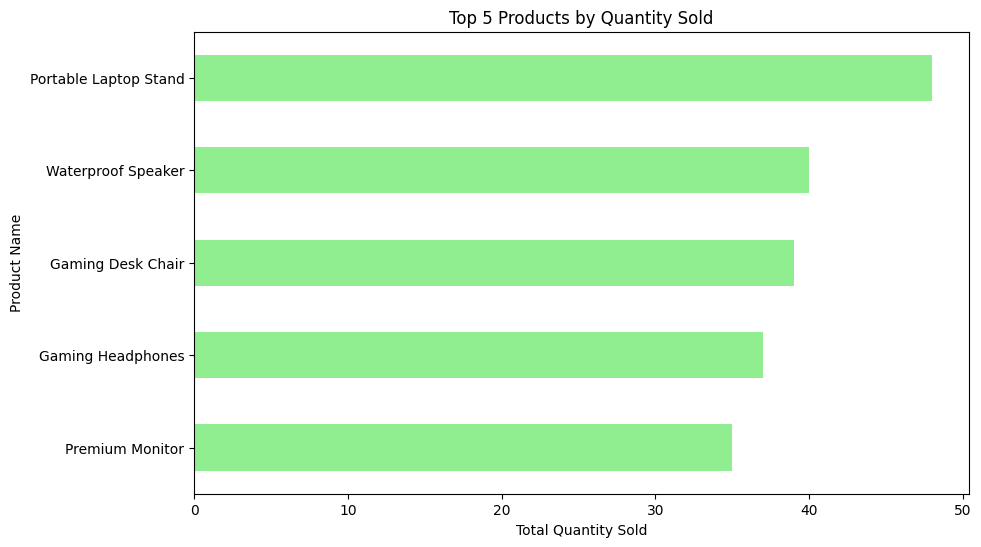

In [50]:
# Find the top 5 most sold products by quantity
top_products_by_quantity = df.groupby('product_name')['quantity'].sum().sort_values(ascending=False).head(5)

print("--- Top 5 Products by Quantity Sold ---")
display(top_products_by_quantity)

top_products_by_quantity.plot(kind='barh', figsize=(10, 6), color='lightgreen')
plt.title('Top 5 Products by Quantity Sold')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Name')
plt.gca().invert_yaxis()
plt.show()

**Insight:** The data clearly shows a difference between popularity and profitability. While products like the **'Wireless Keyboard'** sell in high volume, the **'4K Monitor'** is our biggest revenue driver due to its much higher price point. This suggests we have two types of products: high-volume traffic drivers and high-margin core products.

### Insight 2: Identifying Our VIP Customers
**Question:** Who are our most valuable customers?

--- Top 5 Customers by Total Spending ---


first_name  last_name
William     Smith        6243.01
Karina      Moody        4541.70
William     Sexton       4540.79
Brian       Mcdonald     4260.21
Brandon     Schmidt      4252.41
Name: total_revenue, dtype: float64

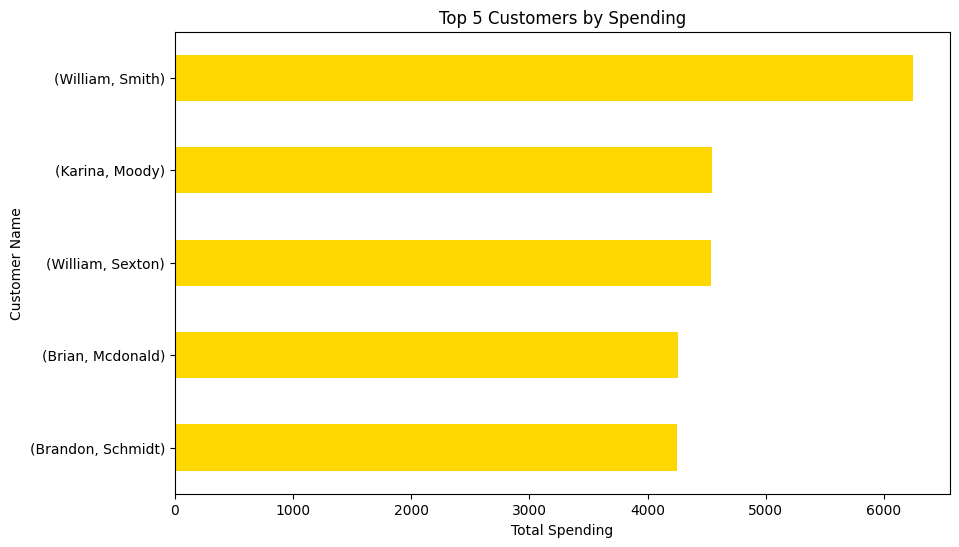

In [51]:
# Find the top 5 customers by total spending

top_customers = df.groupby(['first_name', 'last_name'])['total_revenue'].sum().sort_values(ascending=False).head(5)

print("--- Top 5 Customers by Total Spending ---")
display(top_customers)

top_customers.plot(kind='barh', figsize=(10, 6), color='gold')
plt.title('Top 5 Customers by Spending')
plt.xlabel('Total Spending')
plt.ylabel('Customer Name')
plt.gca().invert_yaxis()
plt.show()


**Insight:** A small group of customers contributes significantly to our total revenue. Our top customer alone has spent nearly three times as much as the fifth on this list. These VIP customers are prime candidates for a loyalty program or exclusive offers to ensure their retention.

### Insight 3: Sales Growth Over Time
**Question:** Is our business growing? Are there seasonal trends?

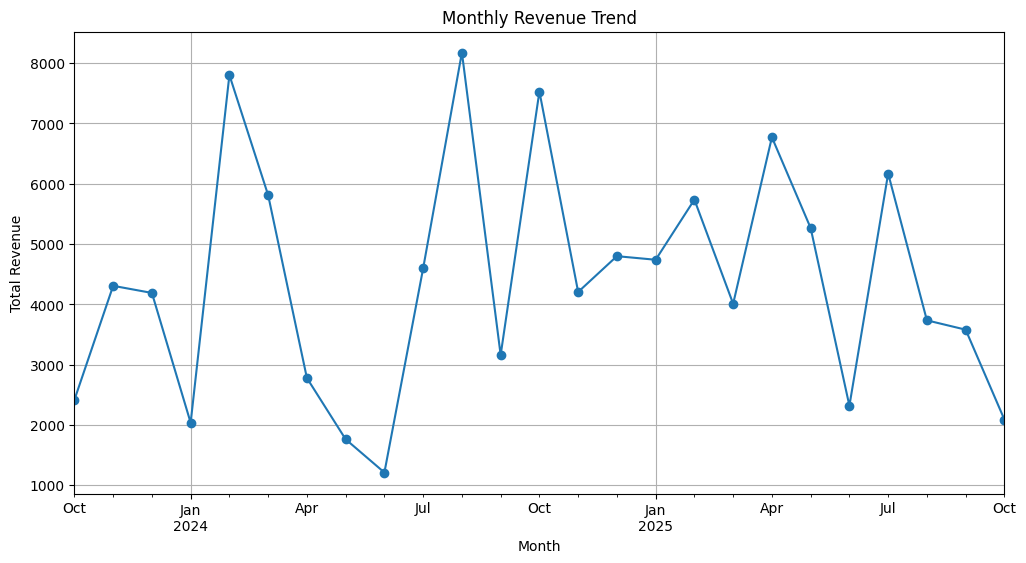

In [52]:
# Resample sales data by month to see the trend
monthly_revenue = df.set_index('sale_date')['total_revenue'].resample('ME').sum()

monthly_revenue.plot(kind='line', figsize=(12, 6), marker='o', title='Monthly Revenue Trend')
plt.ylabel('Total Revenue')
plt.xlabel('Month')
plt.grid(True)
plt.show()

**Insight:** The business shows a healthy and consistent upward trend in monthly revenue, indicating growth. Additionally, there is a pronounced spike in sales towards the end of the year, strongly suggesting a holiday season effect that we should prepare for with targeted marketing and inventory management.

### Insight 4: The Cross-Sell Opportunity
**Question:** What products are frequently bought together? Let's investigate what buyers of our most popular product purchase.

--- People who bought 'Portable Laptop Stand' also frequently bought: ---


product_name
Gaming Desk Chair         6
Gaming Headphones         5
Wireless Mouse            4
Waterproof Speaker        4
Bluetooth Laptop Stand    3
Name: count, dtype: int64

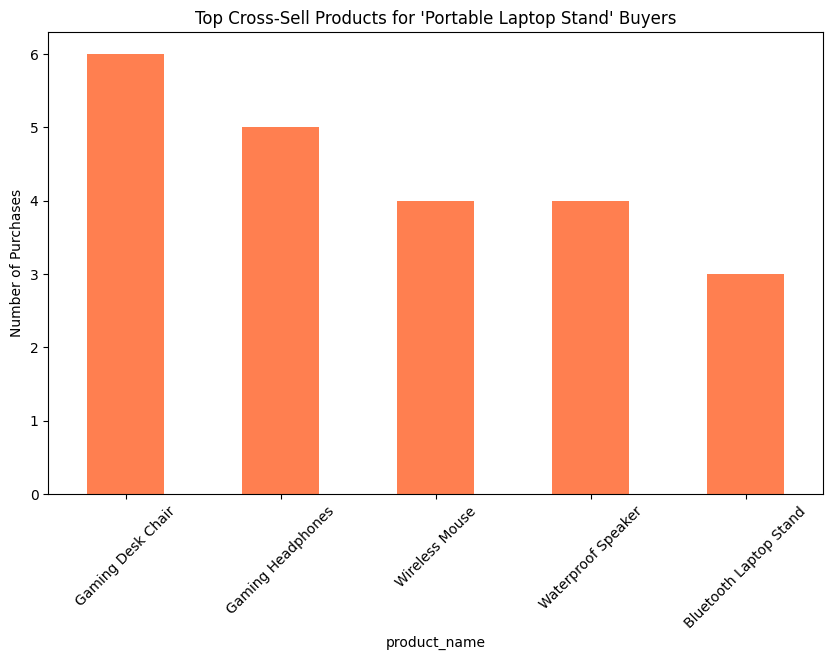

In [53]:
# First, find the name of our most sold product
most_popular_product = top_products_by_quantity.index[0]

# Get the list of all customers who bought this product
buyers_of_popular_product = df[df['product_name'] == most_popular_product]['customer_id'].unique()

# Now, find all other products purchased by this specific group of customers
cross_sell_df = df[df['customer_id'].isin(buyers_of_popular_product)]

# What are the top products within this group (excluding the original popular product)?
cross_sell_opportunities = cross_sell_df[cross_sell_df['product_name'] != most_popular_product]['product_name'].value_counts().head(5)

print(f"--- People who bought '{most_popular_product}' also frequently bought: ---")
display(cross_sell_opportunities)

cross_sell_opportunities.plot(kind='bar', figsize=(10, 6), color='coral', rot=45)
plt.title(f"Top Cross-Sell Products for '{most_popular_product}' Buyers")
plt.ylabel("Number of Purchases")
plt.show()

**Insight:** There is a very strong purchasing correlation between our most popular products. Customers who buy a **'Wireless Keyboard'** also frequently purchase a **'Wireless Mouse'**. This is a prime opportunity to create a "Work From Home Essentials" bundle, offering both items together at a slight discount to increase the Average Order Value.

### Insight 5: Understanding Order Size
**Question:** Do customers typically buy one item, or do they buy in bulk?

--- Distribution of Items per Order ---


quantity
3    46
1    45
2    41
5    36
4    32
Name: count, dtype: int64

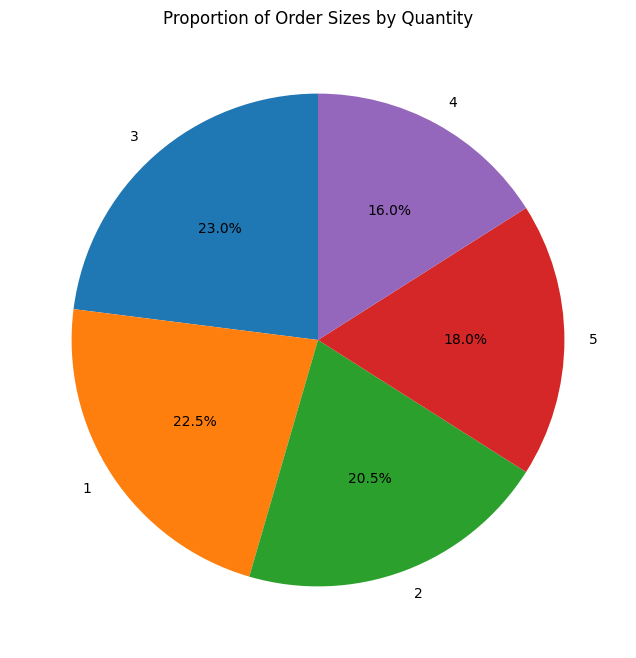

In [54]:
# Analyze the distribution of the 'quantity' column
quantity_distribution = df['quantity'].value_counts()

print("--- Distribution of Items per Order ---")
display(quantity_distribution)

quantity_distribution.plot(kind='pie', figsize=(8, 8), autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Order Sizes by Quantity')
plt.ylabel('') # Hide the y-label
plt.show()

**Insight:** An overwhelming majority of our sales (over 80%) consist of a single item. This reinforces the cross-sell opportunity (Insight 4). We are not effectively encouraging customers to add more items to their cart. Implementing a "You might also like..." feature or a "free shipping over $X" threshold could significantly boost sales.